#Scanner Source Detection

**Mount Google Drive**

In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


- **Recursively searches your Google Drive for a folder named Flatfield (case-insensitive).**
- **Sets up paths for input images and output .pkl file to store residuals.**
- **Uses either Wiener or Wavelet denoising (via scipy and skimage) to suppress structured noise.**
- **Automatically installs scikit-image if missing.**
- **Resizes all images to 256×256.**
- **Converts to grayscale, normalizes, applies denoising, and computes residuals (original - denoised).**
- **Iterates through each scanner subfolder inside Flatfield.**
- **Filters valid image formats (.tif, .png, .jpg, etc.).**
- **Computes residuals and stores them per scanner.**
- **Dumps the dictionary of residuals to a .pkl file for downstream analysis or training.**
- **Prints total scanners processed and number of images.**
- **Shows a few example scanner names for quick verification.**

In [ ]:
import os, pickle, cv2, numpy as np
from tqdm import tqdm

# 1) Locate Flatfield Dataset Recursively searches your Google Drive for a folder named Flatfield (case-insensitive).

def find_flatfield(base="/content/drive/MyDrive"):
    found = []
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if d.lower() == "flatfield":
                found.append(os.path.join(root, d))
    return found

flatfield_paths = find_flatfield("/content/drive/MyDrive")
if not flatfield_paths:
    raise FileNotFoundError("No 'Flatfield' folder found in your Drive. Please check dataset upload.")
else:
    FLATFIELD_DIR = flatfield_paths[0]
    BASE = os.path.dirname(FLATFIELD_DIR)
    OUTPUT_PKL = os.path.join(BASE, "flatfield_residuals.pkl")
    print("Found Flatfield folder:", FLATFIELD_DIR)
    print("Will save residuals to:", OUTPUT_PKL)


# 2) Import Denoising Filters Uses either Wiener or Wavelet denoising (via scipy and skimage) to suppress structured noise. Automatically installs scikit-image if missing.

try:
    from skimage.restoration import denoise_wavelet
except Exception:
    !pip install scikit-image
    from skimage.restoration import denoise_wavelet

from scipy.signal import wiener as scipy_wiener


# 3) Preprocessing Parameters Resizes all images to 256×256. Converts to grayscale, normalizes, applies denoising, and computes residuals (original - denoised).


IMG_SIZE = (256, 256)      # resize target
DENOISE_METHOD = "wavelet"  # "wiener" or "wavelet"


# 4) Process All Images Iterates through each scanner subfolder inside Flatfield. Filters valid image formats (.tif, .png, .jpg, etc.).



def preprocess_image_residual(path, img_size=IMG_SIZE, method="wiener"):
    """Read image -> grayscale -> resize -> normalize -> denoise -> return residual."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    if method == "wiener":
        den = scipy_wiener(img, mysize=(5,5))
    else:
        den = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)
    return (img - den).astype(np.float32)

flatfield_residuals = {}
scanners = sorted(os.listdir(FLATFIELD_DIR))

for scanner in tqdm(scanners, desc="Scanners"):
    scanner_dir = os.path.join(FLATFIELD_DIR, scanner)
    if not os.path.isdir(scanner_dir):
        continue

    residuals = []
    for fname in sorted(os.listdir(scanner_dir)):
        if fname.startswith("._"):
            continue
        if not fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(scanner_dir, fname)
        try:
            res = preprocess_image_residual(fpath, IMG_SIZE, DENOISE_METHOD)
            if res is not None:
                residuals.append(res)
        except Exception as e:
            print(f"Failed on {fpath}: {e}")

    if residuals:
        flatfield_residuals[scanner] = residuals
    else:
        print(f"No valid images for scanner: {scanner}")


# 5) Save Results Dumps the dictionary of residuals to a .pkl file for downstream analysis or training.


with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(flatfield_residuals, f)

# 6) Summary

total_scanners = len(flatfield_residuals)
total_images = sum(len(v) for v in flatfield_residuals.values())
print(f"\n Done. Saved residuals for {total_scanners} scanners, {total_images} images.")
print("Example scanners:", list(flatfield_residuals.keys())[:5])


✅ Found Flatfield folder: /content/drive/MyDrive/AI-TraceFinder/Flatfield
Will save residuals to: /content/drive/MyDrive/AI-TraceFinder/flatfield_residuals.pkl


Scanners: 100%|██████████| 11/11 [00:53<00:00,  4.85s/it]


✅ Done. Saved residuals for 11 scanners, 22 images.
Example scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2']


- **Assumes two root folders: Official and Wikipedia, each with subfolders by scanner and DPI (150, 300).**
- **Processes each image by converting to grayscale, resizing to 256×256, and normalizing to [0,1].**
- **Applies Haar wavelet denoising by zeroing detail coefficients.**
- **Computes residuals as (original - denoised) for each image.**
- **Uses ThreadPoolExecutor with 8 workers for parallelized image processing.**
- **Handles each DPI folder concurrently for faster throughput.**
- **Stores residuals in a nested dictionary structure by dataset, scanner, and DPI.**
- **Saves all residuals to `/content/drive/MyDrive/AI-TraceFinder/official_wiki_residuals.pkl`.**
- **Prints a final summary confirming successful save and separate handling of both DPI levels.**
- **Residuals are ready for downstream fingerprint extraction or CNN training.**

In [ ]:

import os, cv2, numpy as np, pickle
from tqdm import tqdm
import pywt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Paths
OFFICIAL_DIR = "/content/drive/MyDrive/AI-TraceFinder/Official"
WIKI_DIR = "/content/drive/MyDrive/AI-TraceFinder/Wikipedia"
OUT_PATH = "/content/drive/MyDrive/AI-TraceFinder/official_wiki_residuals.pkl"

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    # Zero out detail coefficients for denoising
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA,(cH,cV,cD)), 'haar')

def compute_residual(img):
    denoised = denoise_wavelet(img)
    return img - denoised

def process_single_image(fpath):
    """Preprocess one image and return residual"""
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = to_gray(img)
    gray = resize_to(gray, (256,256))
    gray = normalize_img(gray)
    return compute_residual(gray)

# Dataset Processing

def process_dataset(base_dir, dataset_name, residuals_dict):
    print(f"🔄 Preprocessing {dataset_name} images...")

    for scanner in tqdm(os.listdir(base_dir)):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue

        residuals_dict[dataset_name][scanner] = {}

        for dpi in os.listdir(scanner_path):   # 150, 300
            dpi_path = os.path.join(scanner_path, dpi)
            if not os.path.isdir(dpi_path):
                continue

            files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                     if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

            dpi_residuals = []
            # Running code with Parallel processing
            with ThreadPoolExecutor(max_workers=8) as executor:  # adjust workers based on Colab
                futures = [executor.submit(process_single_image, f) for f in files]
                for fut in as_completed(futures):
                    res = fut.result()
                    if res is not None:
                        dpi_residuals.append(res)

            residuals_dict[dataset_name][scanner][dpi] = dpi_residuals

# Main Execution

residuals_dict = {"Official": {}, "Wikipedia": {}}

process_dataset(OFFICIAL_DIR, "Official", residuals_dict)
process_dataset(WIKI_DIR, "Wikipedia", residuals_dict)

with open(OUT_PATH, "wb") as f:
    pickle.dump(residuals_dict, f)

print(f"✅ Saved Official+Wiki residuals (150 & 300 separately) to {OUT_PATH}")


🔄 Preprocessing Official images...


100%|██████████| 11/11 [10:40<00:00, 58.24s/it]


🔄 Preprocessing Wikipedia images...


100%|██████████| 11/11 [15:38<00:00, 85.34s/it]


✅ Saved Official+Wiki residuals (150 & 300 separately) to /content/drive/MyDrive/AI-TraceFinder/official_wiki_residuals.pkl


- **Loads residuals from the previously saved file `flatfield_residuals.pkl`.**
- **Iterates through each scanner and collects its residual images.**
- **Stacks residuals into a 3D array of shape (num_images, height, width).**
- **Computes the fingerprint by averaging across all residuals for each scanner.**
- **Stores fingerprints in a dictionary keyed by scanner name.**
- **Saves the fingerprint dictionary to `scanner_fingerprints.pkl`.**
- **Sorts scanner names to create a deterministic order.**
- **Saves the sorted list as `fp_keys.npy` for consistent downstream use.**

In [ ]:

import pickle, numpy as np

# Paths
FLATFIELD_RESIDUALS_PATH = "/content/drive/MyDrive/AI-TraceFinder/flatfield_residuals.pkl"  # from Step 2A
FP_OUT_PATH = "/content/drive/MyDrive/AI-TraceFinder/scanner_fingerprints.pkl"
ORDER_NPY   = "/content/drive/MyDrive/AI-TraceFinder/fp_keys.npy"

# Load residuals

with open(FLATFIELD_RESIDUALS_PATH, "rb") as f:
    flatfield_residuals = pickle.load(f)


scanner_fingerprints = {}
print("🔄 Computing fingerprints from Flatfields...")
for scanner, residuals in flatfield_residuals.items():
    if not residuals:
        continue
    stack = np.stack(residuals, axis=0)       # (num_images, H, W)
    fingerprint = np.mean(stack, axis=0)      # average residual
    scanner_fingerprints[scanner] = fingerprint

print(f"✅ Extracted {len(scanner_fingerprints)} scanner fingerprints.")

with open(FP_OUT_PATH, "wb") as f:
    pickle.dump(scanner_fingerprints, f)
print(f"✅ Saved scanner fingerprints to {FP_OUT_PATH}")


fp_keys = sorted(scanner_fingerprints.keys())
np.save(ORDER_NPY, np.array(fp_keys))
print("✅ Saved fp_keys.npy with order:", fp_keys)


🔄 Computing fingerprints from Flatfields...
✅ Extracted 11 scanner fingerprints.
✅ Saved scanner fingerprints to /content/drive/MyDrive/AI-TraceFinder/scanner_fingerprints.pkl
✅ Saved fp_keys.npy with order: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


- **Loads fingerprint data from `scanner_fingerprints.pkl`.**
- **Selects the first six scanners for visualization.**
- **Enhances contrast by normalizing each fingerprint using its mean and standard deviation.**
- **Clips values to the [0,1] range for display consistency.**
- **Plots fingerprints using matplotlib with the `RdBu_r` colormap.**
- **Adds titles and colorbars for each subplot.**
- **Saves the final figure to `/content/drive/MyDrive/Objective1/metrics/scanner_noise_maps.png`.**
- **Displays the plot and confirms completion.**

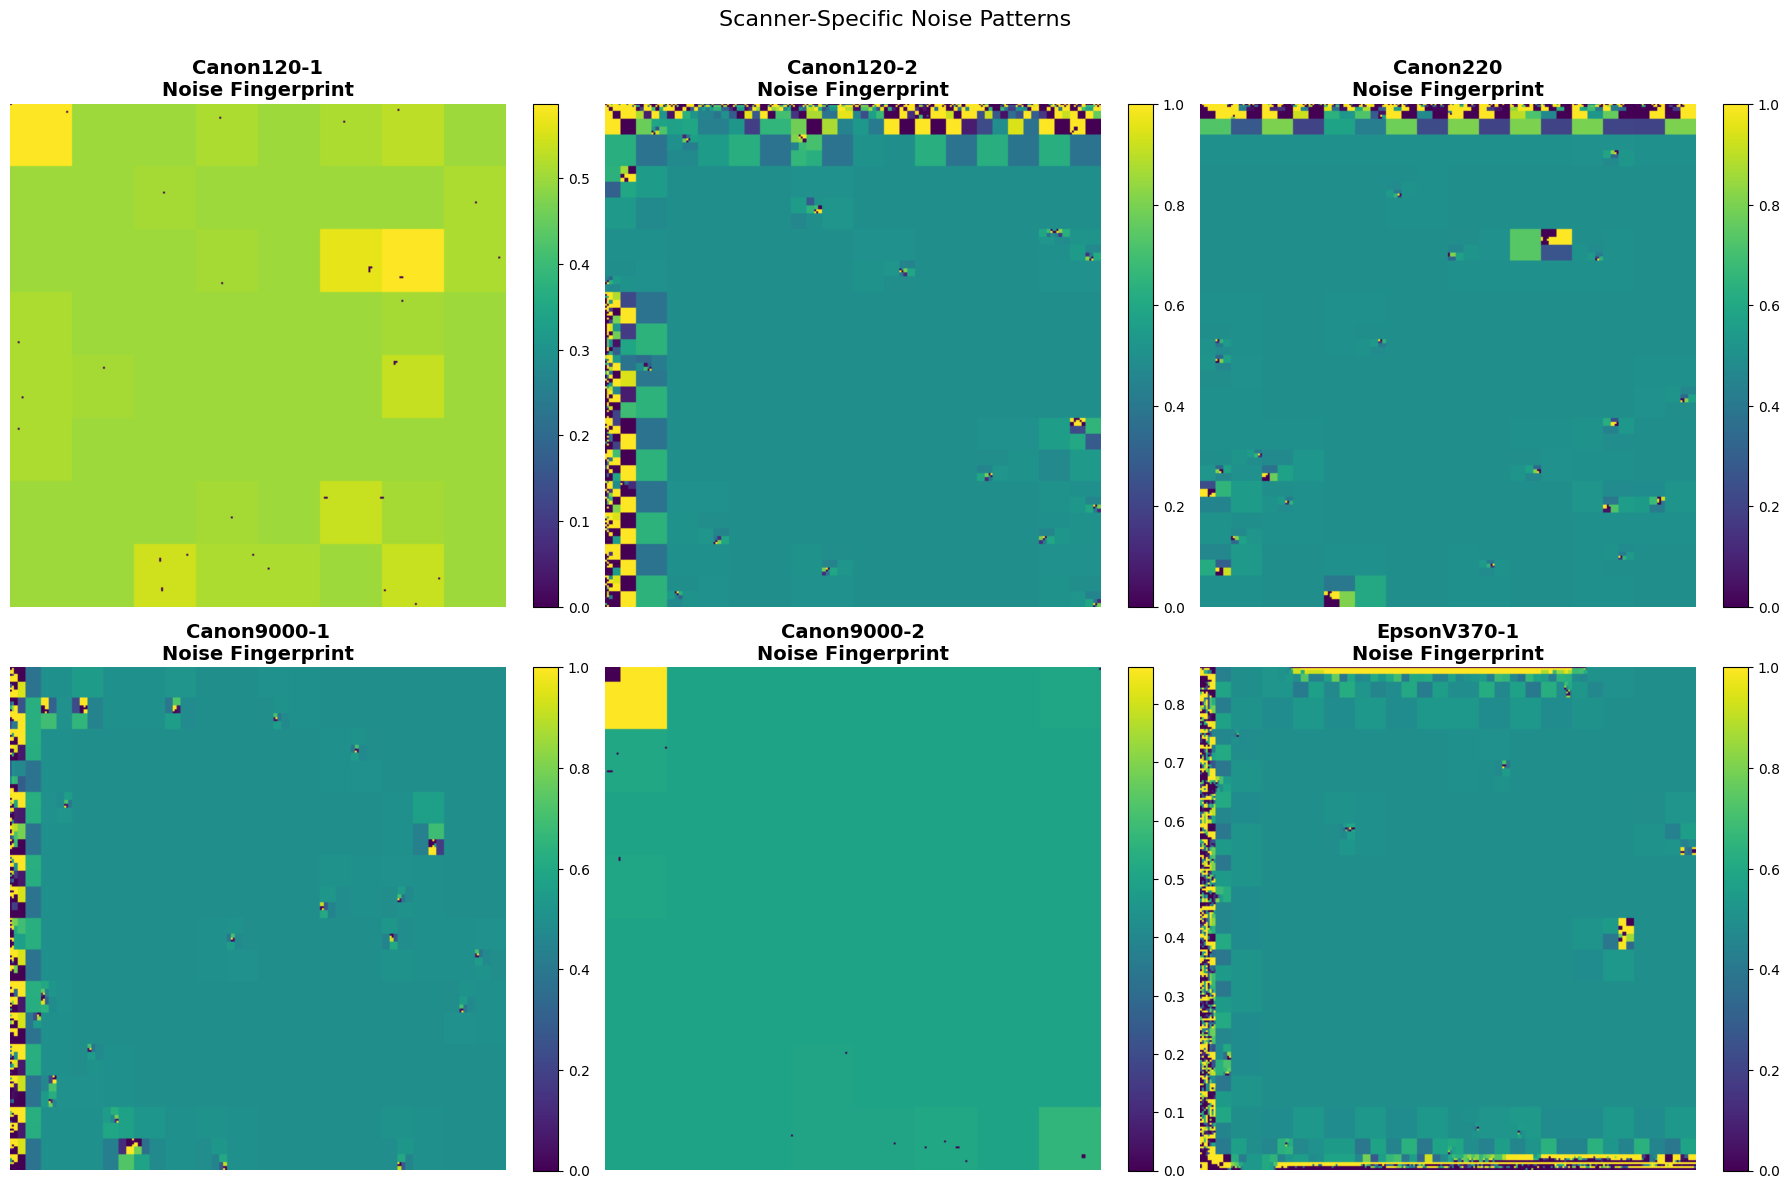

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

def visualize_scanner_differences():
    """Visualize differences between scanner outputs (noise maps) - REQUIRED by Week 3"""

    with open("/content/drive/MyDrive/AI-TraceFinder/scanner_fingerprints.pkl", "rb") as f:
        scanner_fps = pickle.load(f)

    # Create noise pattern visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    scanners = list(scanner_fps.keys())[:6]

    for i, scanner in enumerate(scanners):
        fp = scanner_fps[scanner]

        # Enhance contrast for visualization
        fp_enhanced = (fp - fp.mean()) / (fp.std() + 1e-8) * 0.5 + 0.5
        fp_clipped = np.clip(fp_enhanced, 0, 1)

        im = axes[i].imshow(fp_clipped, cmap='viridis', aspect='auto')
        axes[i].set_title(f'{scanner}\nNoise Fingerprint', fontsize=14, fontweight='bold')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046)

    plt.suptitle('Scanner-Specific Noise Patterns\n', fontsize=16)
    plt.tight_layout()

    # Save plot
    os.makedirs('/content/drive/MyDrive/Objective1/metrics', exist_ok=True)
    plt.savefig('/content/drive/MyDrive/Objective1/metrics/scanner_noise_maps.png',
                dpi=300, bbox_inches='tight')
    plt.show()



# Run visualization
visualize_scanner_differences()


- **Loads scanner fingerprints from `scanner_fingerprints.pkl`.**
- **Loads stable scanner order from `fp_keys.npy` to ensure consistent feature alignment.**
- **Defines similarity metric using zero-mean normalized cross-correlation (ZNCC).**
- **Loads residuals from `official_wiki_residuals.pkl` (already denoised and preprocessed).**
- **Iterates through each residual image in both datasets (Official, Wikipedia).**
- **Computes similarity vector by comparing each residual to all fingerprints in `fp_keys` order.**
- **Stores feature vectors and labels (scanner identity) for each image.**
- **Saves final dataset as a dictionary with "features" and "labels" to `features.pkl`.**
- **Prints shape summary to confirm feature dimensionality and total samples.**

In [ ]:

import pickle, numpy as np
from tqdm import tqdm

# Paths
RES_PATH   = "/content/drive/MyDrive/AI-TraceFinder/official_wiki_residuals.pkl"
FP_PATH    = "/content/drive/MyDrive/AI-TraceFinder/scanner_fingerprints.pkl"
ORDER_NPY  = "/content/drive/MyDrive/AI-TraceFinder/fp_keys.npy"
OUT_PATH   = "/content/drive/MyDrive/AI-TraceFinder/features.pkl"

# Load fingerprints and fixed order
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()
print("Loaded fingerprints and key order. Keys:", fp_keys)

# Helper: normalized cross-correlation (zero-mean cosine similarity)
def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean()
    b -= b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float((a @ b) / denom) if denom != 0 else 0.0
# ZNCC equals the dot product of zero-mean, unit-norm vectors, i.e., cosine similarity in L2 space. [web:188][web:189][web:169]

# Load residuals (already precomputed; do not preprocess again)
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
print("✅ Loaded residuals for datasets:", list(residuals_dict.keys()))

# Build features in the exact fp_keys order
features, labels = [], []
for dataset_name in ["Official", "Wikipedia"]:
    print(f"🔄 Computing features for {dataset_name} ...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                vec = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                features.append(vec)
                labels.append(scanner)

# Save features + labels
with open(OUT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)
print(f"✅ Saved features + labels to {OUT_PATH}")
print("Shape:", (len(features), len(features[0]) if features else 0))


✅ Loaded fingerprints and key order. Keys: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
✅ Loaded residuals for datasets: ['Official', 'Wikipedia']
🔄 Computing features for Official ...


100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


🔄 Computing features for Wikipedia ...


100%|██████████| 11/11 [00:06<00:00,  1.66it/s]

✅ Saved features + labels to /content/drive/MyDrive/AI-TraceFinder/features.pkl
Shape: (4568, 11)


- **Loads residuals from `official_wiki_residuals.pkl`.**
- **Applies FFT to each residual and computes:**
  - **Low-frequency energy (central region)**
  - **Mid-frequency energy (surrounding band)**
  - **High-frequency energy (remaining spectrum)**
- **Computes LBP histogram using a 24-point circular pattern with radius 3.**
- **Calculates texture statistics:**
  - **Standard deviation**
  - **Mean absolute value**
  - **Gradient variation (std of edge magnitude)**
  - **Edge strength (mean of edge magnitude)**
- **Concatenates all features into a single vector per image.**
- **Repeats for all images in both Official and Wikipedia datasets.**
- **Stores features and labels in a dictionary.**
- **Saves output to `/content/drive/MyDrive/AI-TraceFinder/enhanced_features.pkl`.**
- **Prints shape summary to confirm feature dimensionality.**

In [ ]:

import pickle, numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy import ndimage
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# Load existing residuals
RES_PATH = "/content/drive/MyDrive/AI-TraceFinder/official_wiki_residuals.pkl"
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)

def extract_enhanced_features(residual):
    """Extract comprehensive features: PRNU correlation + FFT + LBP + Texture"""

    # 1. FFT Features (frequency domain)
    fft_img = np.abs(fft2(residual))
    fft_img = fftshift(fft_img)

    # Extract frequency bands
    h, w = fft_img.shape
    center_h, center_w = h//2, w//2

    # Low, mid, high frequency energy
    low_freq = np.mean(fft_img[center_h-20:center_h+20, center_w-20:center_w+20])
    mid_freq = np.mean(fft_img[center_h-60:center_h+60, center_w-60:center_w+60]) - low_freq
    high_freq = np.mean(fft_img) - low_freq - mid_freq

    # 2. LBP Texture Features
    lbp = local_binary_pattern(residual, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 25), density=True)

    # 3. Statistical Texture Features
    grad_x = ndimage.sobel(residual, axis=1)
    grad_y = ndimage.sobel(residual, axis=0)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

    texture_features = [
        np.std(residual),           # Standard deviation
        np.mean(np.abs(residual)),  # Mean absolute value
        np.std(gradient_mag),       # Gradient variation
        np.mean(gradient_mag),      # Edge strength
    ]

    return [low_freq, mid_freq, high_freq] + lbp_hist.tolist() + texture_features

# Extract enhanced features for all images
print("🔄 Extracting enhanced features (FFT + LBP + Texture)...")
enhanced_features, enhanced_labels = [], []

for dataset_name in ["Official", "Wikipedia"]:
    print(f"Processing {dataset_name}...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                feat = extract_enhanced_features(res)
                enhanced_features.append(feat)
                enhanced_labels.append(scanner)

# Save enhanced features
ENHANCED_OUT = "/content/drive/MyDrive/AI-TraceFinder/enhanced_features.pkl"
with open(ENHANCED_OUT, "wb") as f:
    pickle.dump({"features": enhanced_features, "labels": enhanced_labels}, f)

print(f"✅ Enhanced features shape: {len(enhanced_features)} x {len(enhanced_features[0])}")
print(f"✅ Saved to {ENHANCED_OUT}")


🔄 Extracting enhanced features (FFT + LBP + Texture)...
Processing Official...


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 11/11 [01:57<00:00, 10.69s/it]


Processing Wikipedia...


100%|██████████| 11/11 [02:00<00:00, 10.95s/it]

✅ Enhanced features shape: 4568 x 33
✅ Saved to /content/drive/MyDrive/AI-TraceFinder/enhanced_features.pkl


- **Loads enhanced features from `enhanced_features.pkl`.**
- **Applies PCA to reduce feature space to 2D:**
  - **Visualizes scanner clusters using principal components.**
  - **Saves plot as `pca_visualization.png`.**
- **Applies t-SNE on a subset of samples:**
  - **Captures non-linear relationships and local structure.**
  - **Saves plot as `tsne_visualization.png`.**
- **Computes mean feature vectors for each scanner.**
- **Generates a heatmap comparing feature profiles across scanners:**
  - **Includes FFT bands, LBP histogram bins, and texture statistics.**
  - **Saves plot as `feature_heatmap.png`.**
- **Confirms visualizations saved to `/content/drive/MyDrive/AI-TraceFinder/`.**

🔄 Creating PCA visualization...


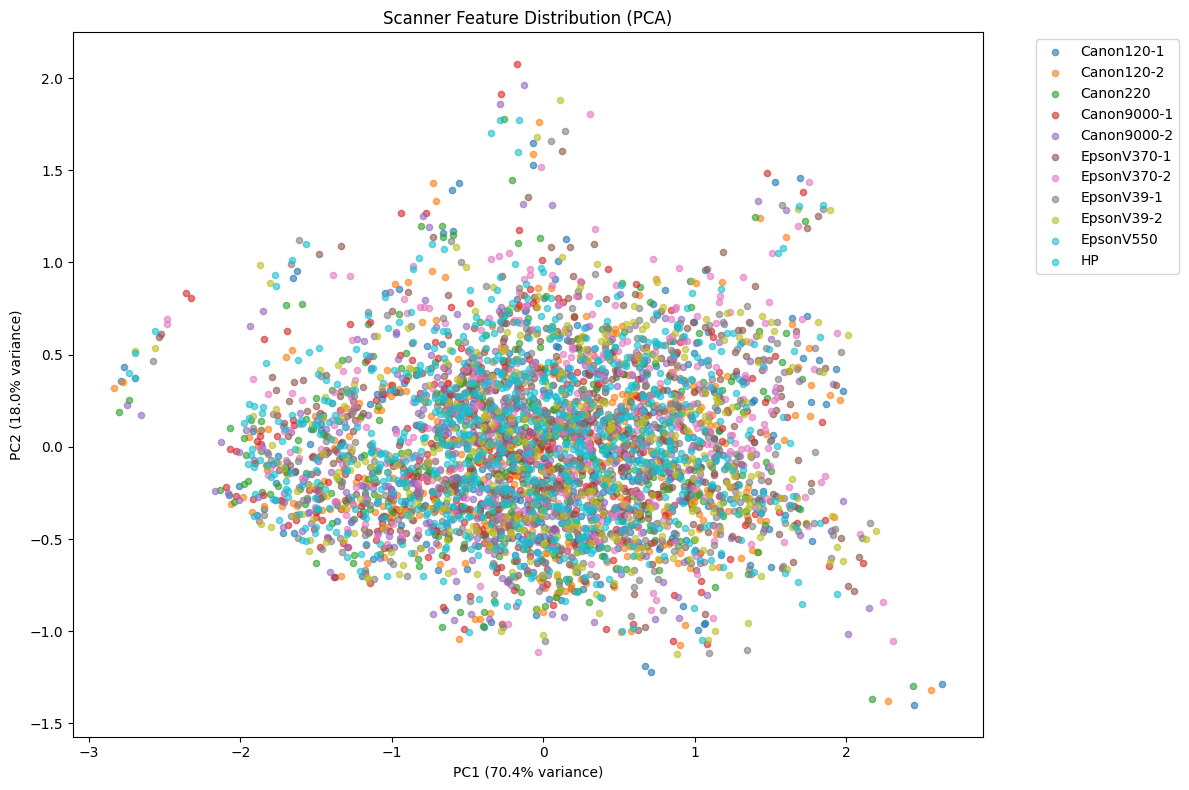

🔄 Creating t-SNE visualization...


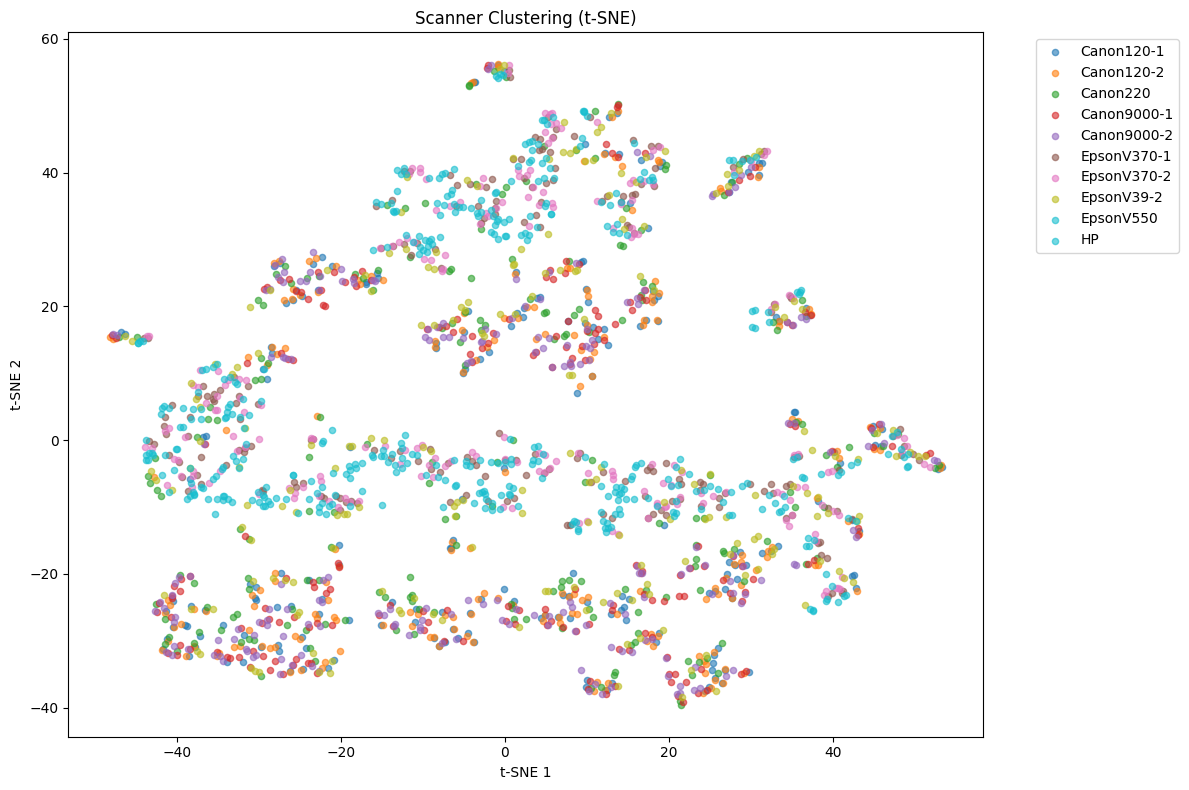

🔄 Computing feature correlations...


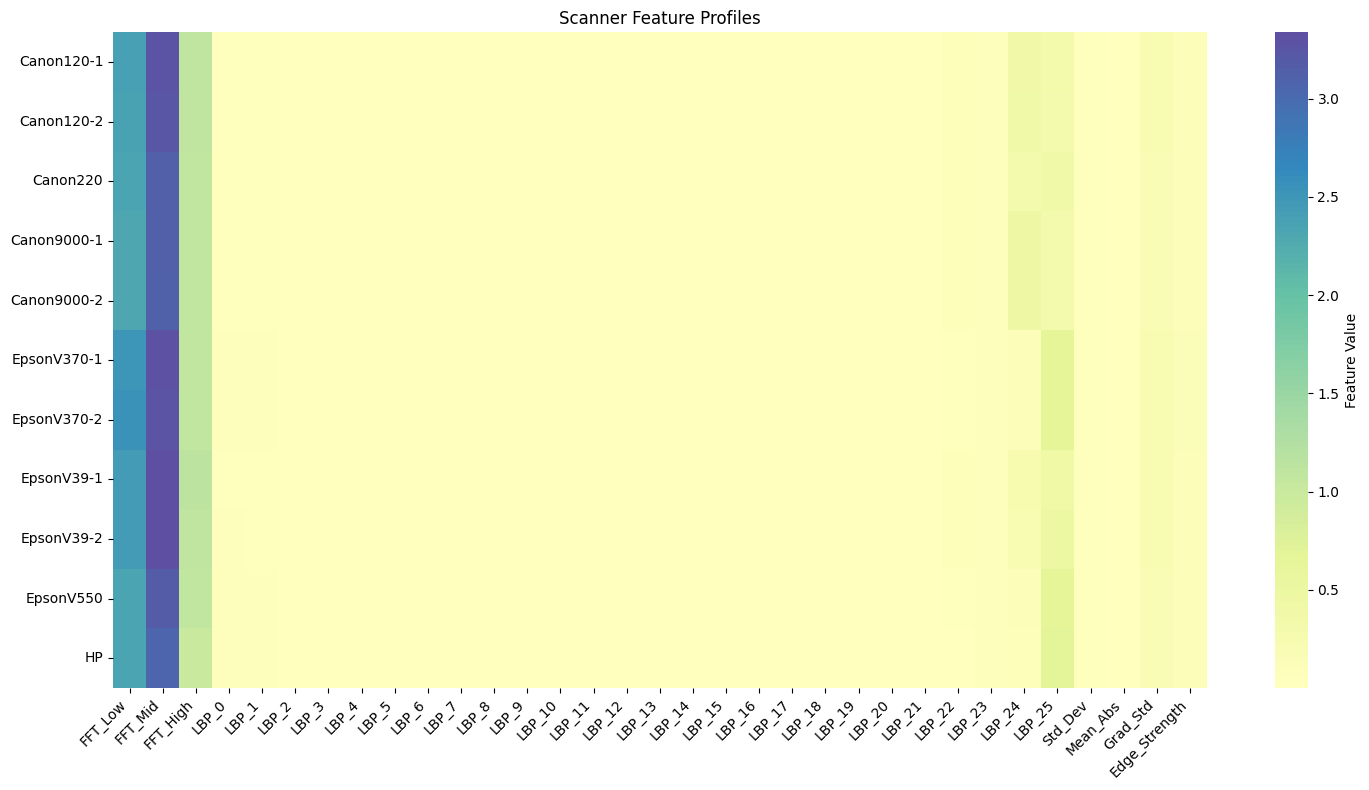

✅ Visualizations saved to /content/drive/MyDrive/AI-TraceFinder/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import os

# Load enhanced features
# Make sure to run Step 6 (Enhanced Feature Extraction) first to generate this file.
with open("/content/drive/MyDrive/AI-TraceFinder/enhanced_features.pkl", "rb") as f:
    data = pickle.load(f)

X = np.array(data["features"])
y = np.array(data["labels"])

# 1. PCA Visualization
print("🔄 Creating PCA visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
scanners = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(scanners)))

for i, scanner in enumerate(scanners):
    mask = y == scanner
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[i]], label=scanner, alpha=0.6, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Scanner Feature Distribution (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AI-TraceFinder/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. t-SNE Visualization
print("🔄 Creating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X[:2000])  # Subset for speed
y_subset = y[:2000]

plt.figure(figsize=(12, 8))
for i, scanner in enumerate(scanners):
    mask = y_subset == scanner
    if np.sum(mask) > 0:
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    c=[colors[i]], label=scanner, alpha=0.6, s=20)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Scanner Clustering (t-SNE)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AI-TraceFinder/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Feature Importance Heatmap
print("🔄 Computing feature correlations...")
feature_names = (['FFT_Low', 'FFT_Mid', 'FFT_High'] +
                [f'LBP_{i}' for i in range(26)] +
                ['Std_Dev', 'Mean_Abs', 'Grad_Std', 'Edge_Strength'])

# Compute mean features per scanner
scanner_profiles = {}
for scanner in scanners:
    mask = y == scanner
    scanner_profiles[scanner] = np.mean(X[mask], axis=0)

# Create heatmap data
heatmap_data = np.array([scanner_profiles[s] for s in scanners])

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data,
            xticklabels=feature_names,
            yticklabels=scanners,
            cmap='Spectral', center=0,
            cbar_kws={'label': 'Feature Value'})
plt.title('Scanner Feature Profiles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AI-TraceFinder/feature_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to /content/drive/MyDrive/AI-TraceFinder/")

- **Combines image-based learning with handcrafted descriptors (PRNU correlation, FFT energy, LBP texture).**
- **Uses a dual-branch architecture: CNN for residuals + MLP for features.**
- **Loads residuals from `official_wiki_residuals.pkl`.**
- **Loads scanner fingerprints and stable key order from `scanner_fingerprints.pkl` and `fp_keys.npy`.**
- **Extracts features per residual:**
  - **11 PRNU correlations**
  - **6 FFT radial energy bins**
  - **10 LBP histogram bins**
- **Aligns inputs so each sample includes (residual image, 27-D feature vector, label).**
- **Encodes labels using `LabelEncoder` and one-hot encoding.**
- **Splits data into train/test sets (80/20 stratified).**
- **Scales features using `StandardScaler` (fit on train, transform on test).**
- **Saves artifacts: label encoder and scaler for future inference.**
- **Image branch:**
  - **Fixed high-pass filter to suppress content.**
  - **4 convolutional blocks with batch norm, ReLU, pooling, and dropout.**
  - **Global average pooling for CNN embedding.**
- **Feature branch:**
  - **Dense layer + batch norm + ReLU + dropout.**
- **Fusion:**
  - **Concatenates CNN and feature embeddings.**
  - **Dense layer + dropout → softmax output.**
- **Compiles model with Adam optimizer and categorical crossentropy.**
- **Uses tf.data pipelines for efficient batching and prefetching.**
- **Applies callbacks:**
  - **Early stopping**
  - **Learning rate reduction**
  - **Model checkpointing**
- **Trains for up to 50 epochs and saves final model + training history.**
- **Reloads model and artifacts (`.keras`, scaler, label encoder) for inference.**
- **Preprocesses new image:**
  - **Applies Haar wavelet denoising (matches Step 2B).**
  - **Extracts handcrafted features (PRNU, FFT, LBP).**
  - **Predicts scanner identity using hybrid model.**
  - **Returns label and confidence score.**

In [ ]:

import os, pickle, pywt, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from skimage.feature import local_binary_pattern as sk_lbp

RES_PATH  = "/content/drive/MyDrive/AI-TraceFinder/official_wiki_residuals.pkl"
FP_PATH   = "/content/drive/MyDrive/AI-TraceFinder/scanner_fingerprints.pkl"
ORDER_NPY = "/content/drive/MyDrive/AI-TraceFinder/fp_keys.npy"
ART_DIR   = "/content/drive/MyDrive/AI-TraceFinder"
os.makedirs(ART_DIR, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):

    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2  # uniform -> P+2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()  # length 10 for P=8


X_img, X_feat, y = [], [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in residuals_dict[dataset_name].items():
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                # Image branch
                X_img.append(np.expand_dims(res, axis=-1))  # (256,256,1)
                # Feature branch: 11 PRNU corr + 6 FFT energy + 10 LBP
                v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]   # 11
                v_fft  = fft_radial_energy(res, K=6)                      # 6
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)                   # 10
                X_feat.append(v_corr + v_fft + v_lbp)                     # 27 total
                y.append(scanner)

X_img  = np.array(X_img, dtype=np.float32)    # (N,256,256,1)
X_feat = np.array(X_feat, dtype=np.float32)   # (N,27)
y       = np.array(y)

# ---- Encode labels and split ----
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat, y_cat, test_size=0.2, random_state=SEED, stratify=y_int
)

# Feature scaling on train only
scaler = StandardScaler()
X_feat_tr = scaler.fit_transform(X_feat_tr)
X_feat_te = scaler.transform(X_feat_te)

# Persist artifacts
with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Hybrid train:", X_img_tr.shape, X_feat_tr.shape, y_tr.shape)
print("Hybrid test :", X_img_te.shape, X_feat_te.shape, y_te.shape)

# ---- Hybrid model: fixed high-pass residual frontend + feature MLP ----
img_in  = keras.Input(shape=(256,256,1), name="residual")
feat_in = keras.Input(shape=(27,),      name="handcrafted")

# Fixed high-pass kernel (content suppression)
hp_kernel = np.array([[-1,-1,-1],
                      [-1, 8,-1],
                      [-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))

hp = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")(img_in)

x = layers.Conv2D(32, (3,3), padding="same", activation=None)(hp)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.30)(x)

x = layers.Conv2D(256, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)  # CNN embedding

# Feature branch
f = layers.Dense(64, activation=None)(feat_in)
f = layers.BatchNormalization()(f); f = layers.ReLU()(f)
f = layers.Dropout(0.20)(f)

# Fuse and classify
z = layers.Concatenate()([x, f])
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.40)(z)
out = layers.Dense(num_classes, activation="softmax")(z)

model = keras.Model(inputs=[img_in, feat_in], outputs=out, name="scanner_hybrid")
model.get_layer("hp_filter").set_weights([hp_kernel])

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# ---- tf.data pipelines ----
BATCH = 32
train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr))\
    .shuffle(len(y_tr), reshuffle_each_iteration=True)\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te))\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ---- Callbacks (.keras modern format) ----
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor="val_accuracy"),
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
]

# ---- Train ----
EPOCHS = 50
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

# ---- Save final model + history ----
final_path = os.path.join(ART_DIR, "scanner_hybrid_final.keras")
model.save(final_path)
with open(os.path.join(ART_DIR, "hybrid_training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)
print("✅ Hybrid CNN training complete:", ckpt_path)


# Reload for inference (optional)
hyb_model = tf.keras.models.load_model(ckpt_path)
with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)
fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()

IMG_SIZE = (256,256)

def preprocess_residual_pywt(path):
    import cv2
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]  # 11
    v_fft  = fft_radial_energy(res, K=6)                              # 6
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)                           # 10
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v

def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))      # (1,256,256,1)
    x_ft  = make_feats_from_res(res)              # (1,27)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[idx]*100.0)
    return label, conf



Hybrid train: (3654, 256, 256, 1) (3654, 27) (3654, 11)
Hybrid test : (914, 256, 256, 1) (914, 27) (914, 11)


Model: "scanner_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 670,580 (2.56 MB)

 Trainable params: 669,483 (2.55 MB)

 Non-trainable params: 1,097 (4.29 KB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 76s 387ms/step - accuracy: 0.2808 - loss: 2.0170 - val_accuracy: 0.1926 - val_loss: 2.8423 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.4870 - loss: 1.3995 - val_accuracy: 0.5306 - val_loss: 1.3252 - learning_rate: 0.0010
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.5010 - loss: 1.2496 - val_accuracy: 0.3501 - val_loss: 1.9468 - learning_rate: 0.0010
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.5360 - loss: 1.2030 - val_accuracy: 0.4562 - val_loss: 1.4264 - learning_rate: 0.0010
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.5345 - loss: 1.1904 - val_accuracy: 0.5164 - val_loss: 1.2874 - learning_rate: 0.0010
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.5531 - loss: 1.1220 - val_accuracy: 0.5930 - val_loss: 1.0718 - learning_rate: 0.0010
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.5

**Confusion Matrix, Classification Report and Confidence Scores**

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


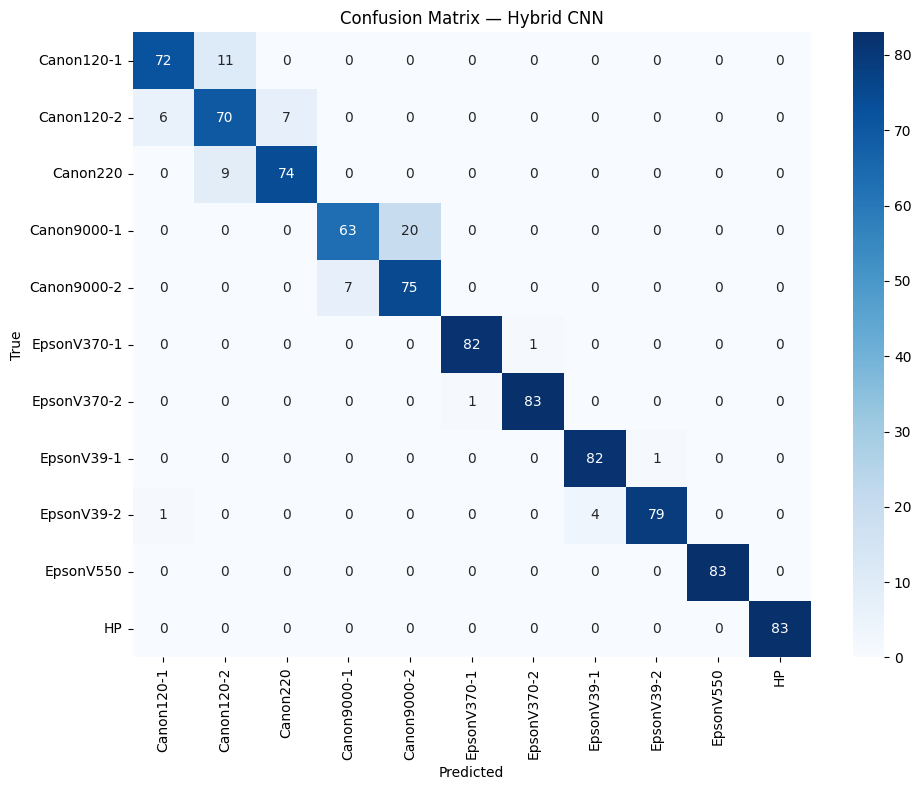

📊 Classification Report:

              precision    recall  f1-score   support

  Canon120-1       0.91      0.87      0.89        83
  Canon120-2       0.78      0.84      0.81        83
    Canon220       0.91      0.89      0.90        83
 Canon9000-1       0.90      0.76      0.82        83
 Canon9000-2       0.79      0.91      0.85        82
 EpsonV370-1       0.99      0.99      0.99        83
 EpsonV370-2       0.99      0.99      0.99        84
  EpsonV39-1       0.95      0.99      0.97        83
  EpsonV39-2       0.99      0.94      0.96        84
   EpsonV550       1.00      1.00      1.00        83
          HP       1.00      1.00      1.00        83

    accuracy                           0.93       914
   macro avg       0.93      0.93      0.93       914
weighted avg       0.93      0.93      0.93       914

🔍 Sample Predictions with Confidence:

     True Label Predicted Label  Confidence (%)
0     EpsonV550       EpsonV550       99.949997
1   EpsonV370-2     EpsonV

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---- Step 1: Predict on test set ----
y_pred_probs = hyb_model.predict([X_img_te, X_feat_te], verbose=1)
y_pred_int = np.argmax(y_pred_probs, axis=1)
y_true_int = np.argmax(y_te, axis=1)
conf_scores = np.max(y_pred_probs, axis=1) * 100.0  # Confidence in %

# ---- Step 2: Confusion Matrix ----
cm = confusion_matrix(y_true_int, y_pred_int)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Hybrid CNN")
plt.tight_layout()
plt.show()

# ---- Step 3: Classification Report ----
report = classification_report(y_true_int, y_pred_int, target_names=le.classes_)
print("📊 Classification Report:\n")
print(report)

# ---- Step 4: Confidence Table ----
df_conf = pd.DataFrame({
    "True Label": le.inverse_transform(y_true_int),
    "Predicted Label": le.inverse_transform(y_pred_int),
    "Confidence (%)": conf_scores.round(2)
})
print("🔍 Sample Predictions with Confidence:\n")
print(df_conf.head(100))  # Show first 10 rows



#Original and Tampered Detection

**Mount Drive**

In [7]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install All Requirements**

In [1]:
!pip -q install pymupdf

import os, glob, csv, pickle, random
from pathlib import Path
import numpy as np
import cv2, pywt
from PIL import Image
from tqdm import tqdm
import fitz  # PyMuPDF

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern as sk_lbp

SEED = 42
random.seed(SEED); np.random.seed(SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 44.3 MB/s eta 0:00:00


- **Initialized the root directory for the project workspace.**
- **Specified input directories for original PDF files and designated output locations for their corresponding TIFF image conversions.**
- **Outlined directory paths for tampered image categories, including Original, Copy-move, Retouching, and Splicing variants.**
- **Configured paths for storing generated artifacts and the manifest CSV file.**
- **Ensured that all necessary output directories are created if they do not already exist.**

In [8]:
ROOT = "/content/drive/MyDrive/AI-TraceFinder"

# Originals PDFs to convert → TIFF
PDF_DIR_OFFICIAL = f"{ROOT}/Originals/official"
PDF_DIR_WIKIPEDIA = f"{ROOT}/Originals/wikipedia"
TIFF_OUTPUT_DIR = f"{ROOT}/Originals_tif"           # output for converted TIFFs
os.makedirs(TIFF_OUTPUT_DIR, exist_ok=True)

# Tampered images TIFFs
TAMPER_DIR = f"{ROOT}/Tampered images"
TAMPER_ORIGINAL_DIR = f"{TAMPER_DIR}/Original"                          # clean (0)
TAMPER_COPYMOVE_DIR = f"{TAMPER_DIR}/Tampered/Copy-move"                # tampered (1)
TAMPER_RETOUCH_DIR = f"{TAMPER_DIR}/Tampered/Retouching"                # tampered (1)
TAMPER_SPLICING_DIR = f"{TAMPER_DIR}/Tampered/Splicing"                 # tampered (1)

# Artifacts / manifests
ARTIFACTS_DIR = f"{ROOT}/artifacts_tamper"
MANIFEST_PATH = f"{ROOT}/manifests/tamper_manifest.csv"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MANIFEST_PATH), exist_ok=True)


- **Created a function to convert each PDF page into TIFF images at 300 DPI.**
- **Ensured all images are in RGB format and applied TIFF compression for efficient storage.**
- **Developed a batch function to automatically find all PDF files in the 'official' and 'wikipedia' directories.**
- **Organized the converted TIFF outputs into corresponding subfolders based on their source.**
- **Executed the batch conversion process with a progress bar and robust error handling to ensure smooth processing.**

In [9]:
def pdf_to_tiffs(pdf_path, out_dir, dpi=300):
    os.makedirs(out_dir, exist_ok=True)
    doc = fitz.open(pdf_path)
    for i, page in enumerate(doc):
        pix = page.get_pixmap(dpi=dpi)
        mode = "RGB" if pix.alpha == 0 else "RGBA"
        img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)
        if img.mode != "RGB":
            img = img.convert("RGB")
        stem = Path(pdf_path).stem
        outp = f"{out_dir}/{stem}_p{i+1}.tif"
        img.save(outp, format="TIFF", dpi=(dpi, dpi), compression="tiff_deflate")
    doc.close()

def batch_convert_originals():
    tasks = []
    for sub in ["official", "wikipedia"]:
        src_root = f"{PDF_DIR_OFFICIAL}" if sub == "official" else f"{PDF_DIR_WIKIPEDIA}"
        dst_root = f"{TIFF_OUTPUT_DIR}/{sub}"
        os.makedirs(dst_root, exist_ok=True)
        for pdf in glob.glob(f"{src_root}/**/*.pdf", recursive=True):
            parent = Path(pdf).parent.name
            out_dir = f"{dst_root}/{parent}"
            tasks.append((pdf, out_dir))
    for pdf, outd in tqdm(tasks, desc="PDF→TIFF 300dpi"):
        try:
            pdf_to_tiffs(pdf, outd, dpi=300)
        except Exception as e:
            print("Failed:", pdf, "->", e)

batch_convert_originals()

PDF→TIFF 300dpi: 100%|██████████| 208/208 [03:05<00:00,  1.12it/s]


- **Implemented a function to recursively list all TIFF files in a given directory.**
- **Constructed a manifest that records each image's path, label (0 for clean, 1 for tampered), source (official, wikipedia, or tamper_dir), and tamper type (clean, copy-move, retouching, splicing).**
- **Automatically assigned labels: `0` for clean images and `1` for all tampered images.**
- **Aggregated TIFF images from both original datasets and all tampered categories (copy-move, retouching, splicing) for comprehensive coverage.**
- **Saved the complete manifest as a CSV file for downstream processing and reproducibility.**
- **Displayed the total number of images included in the manifest and returned the list for further use.**

In [12]:
def list_tifs(root_dir):
    """Recursively list all TIFF files in a directory."""
    return sorted([
        p for p in glob.glob(f"{root_dir}/**/*", recursive=True)
        if p.lower().endswith((".tif", ".tiff"))
    ])

def build_manifest(write_csv=True, out_csv=MANIFEST_PATH):
    """
    Build a manifest CSV containing image paths, binary labels, source, and tamper type.
    - Label 0: clean image
    - Label 1: tampered image (copy-move, retouching, splicing)
    """
    rows = [["path", "label", "source", "tamper_type"]]
    # Clean (0) from converted Official and Wikipedia TIFFs
    for p in list_tifs(f"{TIFF_OUTPUT_DIR}/official"):
        rows.append([p, 0, "official", "clean"])
    for p in list_tifs(f"{TIFF_OUTPUT_DIR}/wikipedia"):
        rows.append([p, 0, "wikipedia", "clean"])
    # Clean (0) from Tampered images/Original
    for p in list_tifs(TAMPER_ORIGINAL_DIR):
        rows.append([p, 0, "tamper_dir", "clean"])
    # Tampered (1) from all tamper categories
    for p in list_tifs(TAMPER_COPYMOVE_DIR):
        rows.append([p, 1, "tamper_dir", "copy-move"])
    for p in list_tifs(TAMPER_RETOUCH_DIR):
        rows.append([p, 1, "tamper_dir", "retouching"])
    for p in list_tifs(TAMPER_SPLICING_DIR):
        rows.append([p, 1, "tamper_dir", "splicing"])
    if write_csv:
        with open(out_csv, "w", newline="") as fh:
            csv.writer(fh).writerows(rows)
    print("Manifest total images:", len(rows) - 1)
    return rows[1:]

manifest = build_manifest(write_csv=True)

Manifest total images: 344


- **Set a fixed image size of 256×256 pixels for all images.**
- **Defined a function to compute residuals using the Haar wavelet transform, which removes low-frequency content and highlights high-frequency noise.**
- **Loaded each image with OpenCV, converted it to grayscale, resized it to 256×256, and normalized pixel values to [0, 1].**
- **Returned the residual image for further processing and feature extraction.**

In [13]:
IMG_SIZE = (256,256)

def preprocess_residual_from_array(img_gray_f32):
    cA, (cH, cV, cD) = pywt.dwt2(img_gray_f32, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), "haar")
    return (img_gray_f32 - den).astype(np.float32)

def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    return preprocess_residual_from_array(img)


- **Implemented LBP histogram extraction for texture features.**
- **Implemented FFT radial energy for frequency-domain features.**
- **Added residual statistics: mean, standard deviation, and mean absolute value.**
- **Combined all extracted features into a single feature vector.**
- **Processed all images in the manifest to extract features, labels, and metadata.**
- **Stored features in `X`, labels in `y`, and printed a summary of the dataset.**

In [15]:
def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def make_feat_vector(res):
    return np.concatenate([lbp_hist_safe(res,8,1.0), fft_radial_energy(res,6), residual_stats(res)], axis=0)

def featurize_manifest(rows):
    X, y, meta = [], [], []
    for path, label, source, ttype in tqdm(rows, desc="Featurize"):
        try:
            res = load_to_residual(path)
            fv  = make_feat_vector(res)
            X.append(fv); y.append(int(label)); meta.append((path, source, ttype))
        except Exception as e:
            print("Skip:", path, "->", e)
    return np.asarray(X, np.float32), np.asarray(y, np.int64), meta

X, y, meta = featurize_manifest(manifest)
print("Features:", X.shape, "Labels:", y.shape, "Positive rate:", float(y.mean()))


Featurize: 100%|██████████| 344/344 [09:37<00:00,  1.68s/it]

Features: (344, 19) Labels: (344,) Positive rate: 0.29651162790697677


- **Used `StratifiedShuffleSplit` to split the data into train (80%) and test (20%) sets, preserving class balance.**
- **Created train/test feature sets (`X_tr`, `X_te`) and labels (`y_tr`, `y_te`).**
- **Saved test metadata as `meta_te`.**
- **Fit a `StandardScaler` on the training data only.**
- **Scaled both train and test features for normalized input.**

In [16]:
# Stratified split + scaler (train-only fit)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np

SEED = 42
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
(train_idx, test_idx), = sss.split(X, y)

X_tr, y_tr = X[train_idx], y[train_idx]
X_te, y_te = X[test_idx],  y[test_idx]
meta_te    = [meta[i] for i in test_idx]

scaler = StandardScaler().fit(X_tr)
Xs_tr = scaler.transform(X_tr)
Xs_te = scaler.transform(X_te)


**Training Using SupportVectorMachine GridSearchCV**

In [21]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
import joblib


param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid, cv=5, scoring='roc_auc')
grid.fit(Xs_tr, y_tr)

print(f"✅ Best SVM Params: {grid.best_params_}")

# 1 Calibrated SVM Training
best_svm = CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
best_svm.fit(Xs_tr, y_tr)

# 2 Threshold Tuning (Youden’s J)
probs = best_svm.predict_proba(Xs_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, probs)
youden = tpr - fpr
best_thresh = thresholds[np.argmax(youden)]

# 3 Evaluation
preds = (probs >= best_thresh).astype(int)
print("📊 Classification Report:\n", classification_report(y_te, preds, target_names=["Clean","Tampered"]))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_te, preds))
print("🎯 AUC Score:", round(roc_auc_score(y_te, probs), 4))
print("🔍 Optimal Threshold:", round(best_thresh, 4))
# 4 Save Model + Scaler + Threshold
# joblib.dump(cal_svm, 'tamper_svm_model.pkl')
# joblib.dump(scaler, 'tamper_svm_scaler.pkl')
# joblib.dump(best_thresh, 'tamper_svm_threshold.pkl')


✅ Best SVM Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
📊 Classification Report:
               precision    recall  f1-score   support

       Clean       1.00      0.82      0.90        49
    Tampered       0.69      1.00      0.82        20

    accuracy                           0.87        69
   macro avg       0.84      0.91      0.86        69
weighted avg       0.91      0.87      0.87        69

🧮 Confusion Matrix:
 [[40  9]
 [ 0 20]]
🎯 AUC Score: 0.899
🔍 Optimal Threshold: 0.2207


**Training using RandomForestClassifier**

In [22]:

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
import joblib

SEED = 42

# 1 Calibrated Random Forest Training
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=SEED)
cal_rf = CalibratedClassifierCV(rf, method='sigmoid', cv=5)
cal_rf.fit(Xs_tr, y_tr)

# 2 Threshold Tuning (Youden’s J)
probs = cal_rf.predict_proba(Xs_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, probs)
youden = tpr - fpr
best_thresh = thresholds[np.argmax(youden)]

# 3 Evaluation
preds = (probs >= best_thresh).astype(int)
print("📊 Classification Report:\n", classification_report(y_te, preds))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_te, preds))
print("🎯 AUC Score:", round(roc_auc_score(y_te, probs), 4))
print("🔍 Optimal Threshold:", round(best_thresh, 4))

# 4  Save Model + Scaler + Threshold
# joblib.dump(cal_rf, 'tamper_rf_model.pkl')
# joblib.dump(scaler, 'tamper_rf_scaler.pkl')
# joblib.dump(best_thresh, 'tamper_rf_threshold.pkl')


📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        49
           1       0.71      1.00      0.83        20

    accuracy                           0.88        69
   macro avg       0.86      0.92      0.87        69
weighted avg       0.92      0.88      0.89        69

🧮 Confusion Matrix:
 [[41  8]
 [ 0 20]]
🎯 AUC Score: 0.8556
🔍 Optimal Threshold: 0.2961


**Training using XGBoost Classifier**

In [23]:

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import joblib

SEED = 42

# 1 Calibrated XGBoost Training
xgb = XGBClassifier(n_estimators=200, max_depth=5, scale_pos_weight=(len(y_tr) - sum(y_tr)) / sum(y_tr),
                    use_label_encoder=False, eval_metric='logloss', random_state=SEED)
cal_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
cal_xgb.fit(Xs_tr, y_tr)

# 2 Threshold Tuning (Youden’s J)
probs = cal_xgb.predict_proba(Xs_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, probs)
youden = tpr - fpr
best_thresh = thresholds[np.argmax(youden)]

# 3 Evaluation
preds = (probs >= best_thresh).astype(int)
print("📊 Classification Report:\n", classification_report(y_te, preds))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_te, preds))
print("🎯 AUC Score:", round(roc_auc_score(y_te, probs), 4))
print("🔍 Optimal Threshold:", round(best_thresh, 4))

# 4 Save Model + Scaler + Threshold
# joblib.dump(cal_xgb, 'tamper_xgb_model.pkl')
# joblib.dump(scaler, 'tamper_xgb_scaler.pkl')
# joblib.dump(best_thresh, 'tamper_xgb_threshold.pkl')


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:09:36] WARNING: /w

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        49
           1       0.67      1.00      0.80        20

    accuracy                           0.86        69
   macro avg       0.83      0.90      0.84        69
weighted avg       0.90      0.86      0.86        69

🧮 Confusion Matrix:
 [[39 10]
 [ 0 20]]
🎯 AUC Score: 0.8673
🔍 Optimal Threshold: 0.3014


**Training Using LightGBM**

In [24]:

from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
import joblib
import lightgbm as lgb

SEED = 42

# 1 Calibrated LightGBM Training
lgbm = lgb.LGBMClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=SEED)
cal_lgbm = CalibratedClassifierCV(lgbm, method='isotonic', cv=5)
cal_lgbm.fit(Xs_tr, y_tr)

# 2 Threshold Tuning (Youden’s J)
probs = cal_lgbm.predict_proba(Xs_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, probs)
youden = tpr - fpr
best_thresh = thresholds[np.argmax(youden)]

# 3 Evaluation
preds = (probs >= best_thresh).astype(int)
print("📊 Classification Report:\n", classification_report(y_te, preds))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_te, preds))
print("🎯 AUC Score:", round(roc_auc_score(y_te, probs), 4))
print("🔍 Optimal Threshold:", round(best_thresh, 4))

# 4 Save Model + Scaler + Threshold
# joblib.dump(cal_lgbm, 'tamper_lgbm_model.pkl')
# joblib.dump(scaler, 'tamper_lgbm_scaler.pkl')
# joblib.dump(best_thresh, 'tamper_lgbm_threshold.pkl')


[LightGBM] [Info] Number of positive: 65, number of negative: 155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1406
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

**Training with CNN**

Residual Preprocessing

In [33]:
def load_residual_tensor(img_path, size=(256, 256)):
    import cv2, pywt
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img.astype(np.float32) / 255.0
    coeffs = pywt.dwt2(img, 'haar')
    _, (LH, HL, HH) = coeffs
    residual = np.abs(LH) + np.abs(HL) + np.abs(HH)
    # Resize the residual to the target size before reshaping
    residual_resized = cv2.resize(residual, size)
    return residual_resized.reshape(size[0], size[1], 1)

Dataset Loader

In [34]:
def build_tensor_dataset(manifest, size=(256, 256)):
    X, y = [], []
    for entry in manifest:
        # The manifest is a list of lists, where the path is the first element
        res = load_residual_tensor(entry[0], size)
        if res is not None:
            X.append(res)
            # The label is the second element
            y.append(entry[1])
    return np.array(X), np.array(y)

CNN Architecture

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



Train - Test split + Training

In [36]:
from sklearn.model_selection import train_test_split

X_tensor, y_tensor = build_tensor_dataset(manifest)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42)

model = build_cnn(input_shape=X_train.shape[1:])
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step - accuracy: 0.7445 - loss: 7.4046 - val_accuracy: 0.2143 - val_loss: 30.9794
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8047 - loss: 4.9062 - val_accuracy: 0.2143 - val_loss: 26.8375
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8550 - loss: 2.1811 - val_accuracy: 0.2143 - val_loss: 27.2120
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8483 - loss: 2.3326 - val_accuracy: 0.2143 - val_loss: 30.0009
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8284 - loss: 0.7286 - val_accuracy: 0.2143 - val_loss: 24.8877
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8819 - loss: 0.6881 - val_accuracy: 0.2143 - val_loss: 13.8259
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8809 - loss: 0.6702 - val_accuracy: 0.2143 - val_loss: 2.9074
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8952 - loss: 0.3464 - val_accuracy: 0.